# Measure-valued gradient estimation

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from measure_valued_gradient import MVDNormal
from reinforce_gradient import ReinforceNormal
from pathwise_gradient import PathwiseNormal


# === EXPERIMENT PARAMETERS ===
seed = 4243254
episodes = 5000
episode_size = 100
learning_rate = 1e-3
optimizer_class = torch.optim.SGD
objective = lambda x: x**2
objective_derivative = lambda x: 2*x

torch.manual_seed(seed)
np.random.seed(seed)

# Generate initial parameters
init_mean = torch.randn(1)
init_cov = torch.eye(1)

estimators = {}

# === Normal Distribution with Measure-Valued Gradient ===
estimators["MVD"] = MVDNormal(objective, int((episode_size + 1) / 2), init_mean.clone(), init_cov.clone())
estimators["MVD coupled"] = MVDNormal(objective, int((episode_size + 1) / 2), init_mean.clone(), init_cov.clone(), coupled=True)

# === Normal Distribution with Log Gradient
estimators["REINFORCE"] = ReinforceNormal(objective, episode_size, init_mean.clone(), init_cov.clone())

# === Create Normal Distribution with Reparameterization-Trick Gradient ===
estimators["Pathwise"] = PathwiseNormal(objective_derivative, episode_size, init_mean.clone(), init_cov.clone())


# Train and save results
results = {}
for i, (name, estimator) in enumerate(estimators.items()):
    optimizer = optimizer_class(estimator.parameters(), lr=learning_rate)
    means = [estimator.mean.clone().detach()]
    covs = [estimator.cov.clone().detach()]
    
    print(f'({i}/{len(estimators)})')
    for episode in range(episodes):
        optimizer.zero_grad()
        loss = estimator(torch.empty(0))
        loss.backward()
        optimizer.step()
        
        means.append(estimator.mean.detach().clone())
        covs.append(estimator.cov.detach().clone())
    
    results[name] = (means, covs, estimator.losses)

(0/3)
(1/3)
(2/3)


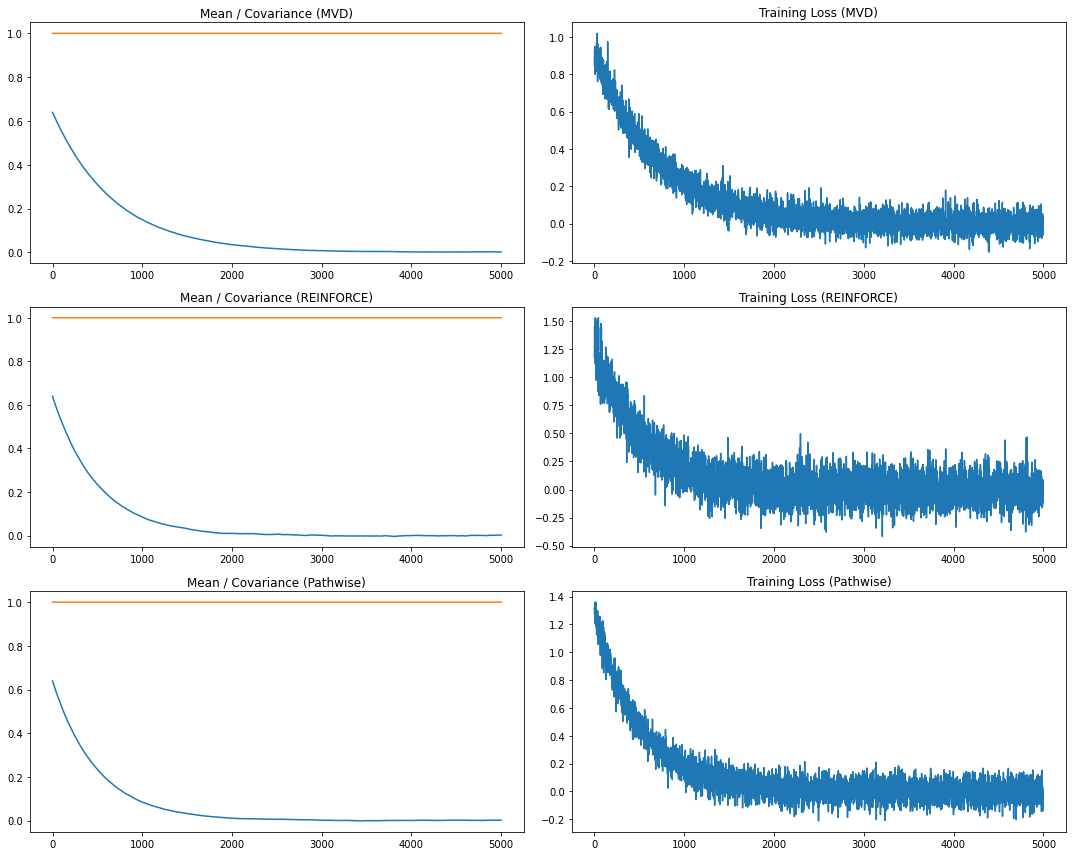

In [2]:
fig, axes = plt.subplots(nrows=len(results), ncols=2, figsize=(15, 4*len(results)))

for i, (name, (means, covs, losses)) in enumerate(results.items()):
    axis = axes[i] if len(results) > 1 else axes
    axis[0].plot(means)
    axis[0].plot(covs)
    axis[0].set_title(f'Mean / Covariance ({name})')
    axis[1].plot(losses)
    axis[1].set_title(f'Training Loss ({name})')

fig.tight_layout()

plt.show()